# HD143006 Tutorial Part 2

This tutorial will follow the MPoL tutorials on [Optimization](https://mpol-dev.github.io/MPoL/tutorials/optimization.html) and [Cross Validation](https://mpol-dev.github.io/MPoL/tutorials/crossvalidation.html) and will use ideas discussed in the [GPU Acceleration](https://mpol-dev.github.io/MPoL/tutorials/gpu_setup.html) tutorial. We assume that users have familiarized themselves with these tutorials here. This tutorial also is a continuation of the [HD143006 Part 1](https://mpol-dev.github.io/MPoL/tutorials/HD143006_Part_1.html) and it is assumed that users have knowledge of this as well.

### Loading Data
Let's load the data as we did in the previous HD143006 tutorial ([Part 1](https://mpol-dev.github.io/MPoL/tutorials/HD143006_Part_1.html)) and create the MPoL Gridder object.

*You can either download these two files (HD143006_continuum.fits and HD143006_continuum.npz) directly to your working directory, or use astropy to download them during run time.*

### Going to need to remove the areas where I wrote about GPU acceleration, but I am just going to remove the gpu code and then update the git repo

In [28]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.utils.data import download_file

# downloading fits file
fname_F = download_file(
   'https://almascience.nrao.edu/almadata/lp/DSHARP/images/HD143006_continuum.fits',
   cache=True,
   pkgname='mpol',
)
# downloading extracted visibilities file
fname_EV = download_file(
    'https://zenodo.org/record/4904794/files/HD143006_continuum.npz',
    cache=True,
    pkgname='mpol',
)
# load extracted visibilities from npz file
dnpz = np.load(fname_EV) 
uu = dnpz['uu']
vv = dnpz['vv']
weight = dnpz['weight']
data = dnpz['data']
# opening the fits file
dfits = fits.open(fname_F)
cdelt_scaling = dfits[0].header['CDELT1'] * 3600 # scaling [arcsec]
cell_size = abs(cdelt_scaling) # [arcsec]
#close fits file
dfits.close()

In [29]:
from mpol import gridding, coordinates
# creating Gridder object
coords = coordinates.GridCoords(cell_size=cell_size, npix=512)
gridder = gridding.Gridder(
    coords = coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data.real, # seperating the real and imaginary values of our data
    data_im=data.imag
)

We now have everything from the last tutorial loaded. Now we can begin the process of Optimization and Cross Validation to improve our image quality. First, we are going to get the dirty image from our gridder object. We will use the Briggs weighting scale and `robust=0.0` here as these options lead to an already well optimized image (see [Part 1](https://mpol-dev.github.io/MPoL/tutorials/HD143006_Part_1.html)). We will also be moving this image to the GPU for faster processing (see [GPU Acceleration](https://mpol-dev.github.io/MPoL/tutorials/gpu_setup.html)).

In [30]:
import torch
img, beam = gridder.get_dirty_image(weighting="briggs", robust=0.0, unit="Jy/arcsec^2")
# taking the dirty image and making it a tensor
dirty_image = torch.tensor(img.copy())

*Note: The rest of this tutorial assumes `device=cuda:0`*

Now we create the model and move this to the GPU as well.

In [31]:
from mpol.precomposed import SimpleNet
model = SimpleNet(coords=coords, nchan=gridder.nchan)

Now that we have our model and data, we need a loss function so we can help direct the Neural Network's learning. For this tutorial, will will use the MSELoss function which is part of the PyTorch library. We also want to create a Writer object so we can observe our Network's state at any point.

*(i think this is correct about the writer, a little unsure)*

In [32]:
from torch.utils.tensorboard import SummaryWriter
loss = torch.nn.MSELoss()
writer = SummaryWriter()

Now let us create a training function to train our SimpleNet

In [33]:
def train(model, dset, config, optimizer, loss_fn, writer):
    model.train()
    for iteration in range(config['epochs']):
        optimizer.zero_grad()
        model.forward()
        sky_cube = model.icube.sky_cube
        loss = loss_fn(sky_cube, dirty_image)
        writer.add_scalar("loss", loss.item(), iteration)
        loss.backward()
        optimizer.step()
    # save the model
    torch.save(model.state_dict(), 'model.pt')

Now lets make our optimizer and our `config` variable. For the optimizer we will be following the [Cross Validation](https://mpol-dev.github.io/MPoL/tutorials/crossvalidation.html) tutorial and for the `config` we will start with a non-agressive learning rate and a low number of epochs.

In [34]:
config = {'lr': 0.5, 'epochs': 500}
optim = torch.optim.Adam(model.parameters(), lr=config['lr'])

Finally, lets run our training function and then plot the results.

In [35]:
train(model, dirty_image, config, optim, loss, writer)

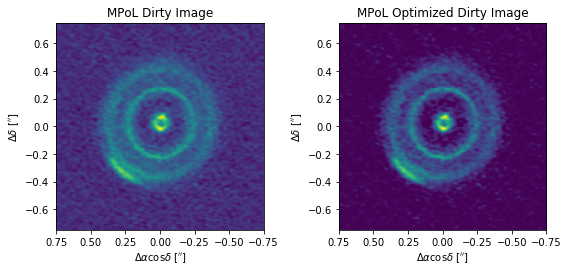

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

im = ax[0].imshow(
    np.squeeze(dirty_image.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)

im = ax[1].imshow(
    np.squeeze(model.icube.sky_cube.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)

ax[0].set_xlim(left=.75, right=-.75)
ax[0].set_ylim(bottom=-.75, top=.75)
ax[0].set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax[0].set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
ax[0].set_title('MPoL Dirty Image')
ax[1].set_xlim(left=.75, right=-.75)
ax[1].set_ylim(bottom=-.75, top=.75)
ax[1].set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax[1].set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
ax[1].set_title('MPoL Optimized Dirty Image')
plt.tight_layout()

Will be changing code around and updating this a little, just wanted to see the as-is results from optimization loop


Now we will move into the realm of Cross Validation. To do this we will be utilizing the [Ray[Tune]](https://docs.ray.io/en/master/tune/index.html) python package for hyperparameter tuning. In order to get the best fit, we will be modifying our `train` function to encorperate a stronger loss function. We will import this from `mpol.losses`. We also need the `mpol.connectors` package because ....?.... Let us do that now.

In [44]:
from mpol import losses, connectors
def train(model, dataset, optimizer, config, writer=None, report=False, logevery=50):
    model.train()
    residuals = connectors.GriddedResidualConnector(model.fcube, dataset)
    for iteration in range(config["epochs"]):
        optimizer.zero_grad()
        vis = model.forward()
        sky_cube = model.icube.sky_cube
        # computing loss through MPoL loss function with more parameters
        loss = (
            losses.nll_gridded(vis, dataset)
            + config["lambda_sparsity"] * losses.sparsity(sky_cube)
            + config["lambda_TV"] * losses.TV_image(sky_cube)
            + config["entropy"] * losses.entropy(sky_cube, config["prior_intensity"])
        )

        if (iteration % logevery == 0) and writer is not None:
            writer.add_scalar("loss", loss.item(), iteration)
            writer.add_figure("image", log_figure(model, residuals), iteration)

        loss.backward()
        optimizer.step()
    if report:
        tune.report(loss=loss.item())

    return loss.item()

Just like in the [Cross Validation tutorial](https://mpol-dev.github.io/MPoL/tutorials/crossvalidation.html) we will need a `test` function and a `cross_validate` function. We impliment these below.

In [38]:
def test(model, dataset):
    model.eval()
    vis = model.forward()
    loss = losses.nll_gridded(vis, dataset)
    return loss.item()

In [67]:
def cross_validate(model, config, k_fold_datasets, MODEL_PATH, writer=None):
    test_scores = []

    for k_fold, (train_dset, test_dset) in enumerate(k_fold_datasets):
        # reset model
        model.load_state_dict(model_state)
        
        # create a new optimizer for this k_fold
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

        # train for a while
        train(model, train_dset, optimizer, config, writer=writer, report=True)
        # evaluate the test metric
        test_scores.append(test(model, test_dset))

    # aggregate all test scores and sum to evaluate cross val metric
    test_score = np.sum(np.array(test_scores))

    # log to ray tune
    tune.report(cv_score=test_score)

    return test_score


Now we will impliment hyperparameter tuning with Ray\[Tune\]. To do this, we need a function that only takes a `config` variable as input. We will call this `trainable`. Using Ray\[Tune\] is rather straight forward. You set up a `tune.run()` object with your function and the parameters and it will calculate the best parameters (this needs to be worded better).

In [68]:
def trainable(config):
    cross_validate(model, config, k_fold_datasets, model_state)

In [69]:
from mpol import datasets
dartboard = datasets.Dartboard(coords=coords)
dataset = gridder.to_pytorch_dataset()
# create cross validator using this "dartboard"
k = 5
cv = datasets.KFoldCrossValidatorGridded(dataset, k, dartboard=dartboard, npseed=42)
k_fold_datasets = [(train, test) for (train, test) in cv]

In [70]:
from ray import tune
import ray
ray.shutdown()
ray.init()
MODEL_PATH = './model.pt'
model_state = torch.load(MODEL_PATH)
analysis = tune.run(trainable,
                    config={
                        "lr": 0.3,
                        "lambda_sparsity": tune.loguniform(1e-8, 1e-4),
                        "lambda_TV": tune.loguniform(1e-4, 1e1),
                        "entropy": tune.loguniform(1e-7, 1e-1),
                        "prior_intensity": tune.loguniform(1e-8, 1e-4),
                        "epochs": 1000,
                    },
                    resources_per_trial={"gpu": 1, "cpu": 3},
                   )
print('Best config: ', analysis.get_best_config(metric='cv_score', mode='min'))

2021-06-16 17:58:13,179	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265
2021-06-16 18:01:12,376	WARNING worker.py:1114 -- Warning: The actor ImplicitFunc has size 353978270 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-16 18:01:15,360	WARNING util.py:162 -- The `start_trial` operation took 77.410 s, which may be a performance bottleneck.


Trial name,status,loc,entropy,lambda_TV,lambda_sparsity,prior_intensity
trainable_109ec_00000,RUNNING,,1.97139e-05,0.123575,2.3037e-08,8.56887e-05


(pid=13756) C:\Users\quinn\Anaconda3\lib\site-packages\torch\autograd\__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:219.)
(pid=13756)   allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Result for trainable_109ec_00000:
  date: 2021-06-16_18-04-09
  done: false
  experiment_id: dbd356abff0b494090199a38b89d7658
  hostname: DESKTOP-5HDQ3TC
  iterations_since_restore: 1
  loss: 22.343003030141595
  node_ip: 192.168.86.39
  pid: 13756
  time_since_restore: 153.2022693157196
  time_this_iter_s: 153.2022693157196
  time_total_s: 153.2022693157196
  timestamp: 1623881049
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 109ec_00000
  


Trial name,status,loc,entropy,lambda_TV,lambda_sparsity,prior_intensity,iter,total time (s),loss
trainable_109ec_00000,RUNNING,192.168.86.39:13756,1.97139e-05,0.123575,2.3037e-08,8.56887e-05,1,153.202,22.343


Result for trainable_109ec_00000:
  date: 2021-06-16_18-06-52
  done: false
  experiment_id: dbd356abff0b494090199a38b89d7658
  hostname: DESKTOP-5HDQ3TC
  iterations_since_restore: 2
  loss: 21.18990585290813
  node_ip: 192.168.86.39
  pid: 13756
  time_since_restore: 315.561829328537
  time_this_iter_s: 162.35956001281738
  time_total_s: 315.561829328537
  timestamp: 1623881212
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 109ec_00000
  


Trial name,status,loc,entropy,lambda_TV,lambda_sparsity,prior_intensity,iter,total time (s),loss
trainable_109ec_00000,RUNNING,192.168.86.39:13756,1.97139e-05,0.123575,2.3037e-08,8.56887e-05,2,315.562,21.1899


Result for trainable_109ec_00000:
  date: 2021-06-16_18-09-30
  done: false
  experiment_id: dbd356abff0b494090199a38b89d7658
  hostname: DESKTOP-5HDQ3TC
  iterations_since_restore: 3
  loss: 19.824292028028985
  node_ip: 192.168.86.39
  pid: 13756
  time_since_restore: 473.7712001800537
  time_this_iter_s: 158.20937085151672
  time_total_s: 473.7712001800537
  timestamp: 1623881370
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 109ec_00000
  


Trial name,status,loc,entropy,lambda_TV,lambda_sparsity,prior_intensity,iter,total time (s),loss
trainable_109ec_00000,RUNNING,192.168.86.39:13756,1.97139e-05,0.123575,2.3037e-08,8.56887e-05,3,473.771,19.8243


Result for trainable_109ec_00000:
  date: 2021-06-16_18-12-00
  done: false
  experiment_id: dbd356abff0b494090199a38b89d7658
  hostname: DESKTOP-5HDQ3TC
  iterations_since_restore: 4
  loss: 21.197318562905263
  node_ip: 192.168.86.39
  pid: 13756
  time_since_restore: 623.3438348770142
  time_this_iter_s: 149.57263469696045
  time_total_s: 623.3438348770142
  timestamp: 1623881520
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 109ec_00000
  


Trial name,status,loc,entropy,lambda_TV,lambda_sparsity,prior_intensity,iter,total time (s),loss
trainable_109ec_00000,RUNNING,192.168.86.39:13756,1.97139e-05,0.123575,2.3037e-08,8.56887e-05,4,623.344,21.1973


Result for trainable_109ec_00000:
  date: 2021-06-16_18-14-26
  done: false
  experiment_id: dbd356abff0b494090199a38b89d7658
  hostname: DESKTOP-5HDQ3TC
  iterations_since_restore: 5
  loss: 19.939186542819392
  node_ip: 192.168.86.39
  pid: 13756
  time_since_restore: 770.1006779670715
  time_this_iter_s: 146.75684309005737
  time_total_s: 770.1006779670715
  timestamp: 1623881666
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 109ec_00000
  


Trial name,status,loc,entropy,lambda_TV,lambda_sparsity,prior_intensity,iter,total time (s),loss
trainable_109ec_00000,RUNNING,192.168.86.39:13756,1.97139e-05,0.123575,2.3037e-08,8.56887e-05,5,770.101,19.9392


Result for trainable_109ec_00000:
  cv_score: 61.552265918358216
  date: 2021-06-16_18-14-26
  done: true
  experiment_id: dbd356abff0b494090199a38b89d7658
  experiment_tag: 0_entropy=1.9714e-05,lambda_TV=0.12357,lambda_sparsity=2.3037e-08,prior_intensity=8.5689e-05
  hostname: DESKTOP-5HDQ3TC
  iterations_since_restore: 6
  node_ip: 192.168.86.39
  pid: 13756
  time_since_restore: 770.1546766757965
  time_this_iter_s: 0.053998708724975586
  time_total_s: 770.1546766757965
  timestamp: 1623881666
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 109ec_00000
  


Trial name,status,loc,entropy,lambda_TV,lambda_sparsity,prior_intensity,iter,total time (s),cv_score
trainable_109ec_00000,TERMINATED,,1.97139e-05,0.123575,2.3037e-08,8.56887e-05,6,770.155,61.5523


2021-06-16 18:14:27,063	INFO tune.py:549 -- Total run time: 964.03 seconds (922.75 seconds for the tuning loop).


Best config:  {'lr': 0.3, 'lambda_sparsity': 2.3036990230378638e-08, 'lambda_TV': 0.12357483710912182, 'entropy': 1.9713872690045363e-05, 'prior_intensity': 8.568869785189019e-05, 'epochs': 1000}


(pid=13756) Windows fatal exception: access violation
(pid=13756) 


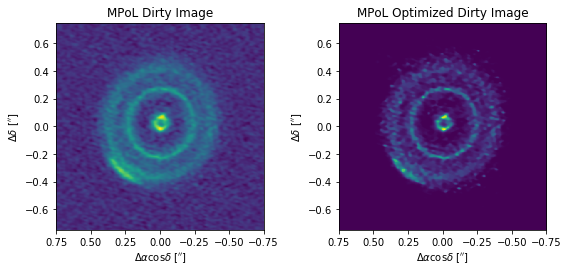

In [71]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

im = ax[0].imshow(
    np.squeeze(dirty_image.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)

im = ax[1].imshow(
    np.squeeze(model.icube.sky_cube.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)

ax[0].set_xlim(left=.75, right=-.75)
ax[0].set_ylim(bottom=-.75, top=.75)
ax[0].set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax[0].set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
ax[0].set_title('MPoL Dirty Image')
ax[1].set_xlim(left=.75, right=-.75)
ax[1].set_ylim(bottom=-.75, top=.75)
ax[1].set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax[1].set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
ax[1].set_title('MPoL Optimized Dirty Image')
plt.tight_layout()

In [62]:
torch.save(model.state_dict(), 'model1.pt')